[View in Colaboratory](https://colab.research.google.com/github/udithv/DeepLearning/blob/master/rnn_tf.ipynb)

#RNN

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
np.random.rand(2, 5)

array([[0.14318308, 0.25371817, 0.87518775, 0.8901737 , 0.11780776],
       [0.14102631, 0.838959  , 0.70328238, 0.46309397, 0.24994617]])

In [0]:
class TimeSeriesData():
  
  def __init__(self, num_points, xmin, xmax):
    
    self.xmin = xmin
    self.xmax = xmax
    self.num_points = num_points
    self.resolution = (xmax - xmin) / num_points
    self.x_data = np.linspace(xmin, xmax, num_points)
    self.y_true = np.sin(self.x_data)
    
  
  def ret_true(self, x_series):
      return np.sin(x_series)
  
  def next_batch(self, batch_size, steps, return_batch_ts=False):
    
    # Grab a random starting point  for each batch of data
    rand_start = np.random.rand(batch_size, 1)
    
    
    # Convert to be on time series
    ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
    
    
    # Create a batch time series on the  x axis
    batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
    
    
    # Create the Y data for the time series x axis from previous step
    y_batch = np.sin(batch_ts)
    
    # Formatting it for the recurrent neural network
    if return_batch_ts:
      return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
    else:
      return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
     

In [0]:
ts_data = TimeSeriesData(250, 0, 10)

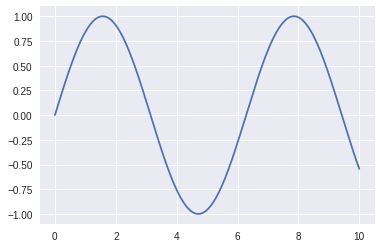

In [5]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [0]:
num_time_steps = 30

In [0]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [8]:
 ts

array([[6.10894537, 6.14894537, 6.18894537, 6.22894537, 6.26894537,
        6.30894537, 6.34894537, 6.38894537, 6.42894537, 6.46894537,
        6.50894537, 6.54894537, 6.58894537, 6.62894537, 6.66894537,
        6.70894537, 6.74894537, 6.78894537, 6.82894537, 6.86894537,
        6.90894537, 6.94894537, 6.98894537, 7.02894537, 7.06894537,
        7.10894537, 7.14894537, 7.18894537, 7.22894537, 7.26894537,
        7.30894537]])

In [9]:
ts.shape 

(1, 31)

In [10]:
y1.shape

(1, 30, 1)

In [11]:
np.array([[[32, 42], [23,45]]]).shape


(1, 2, 2)

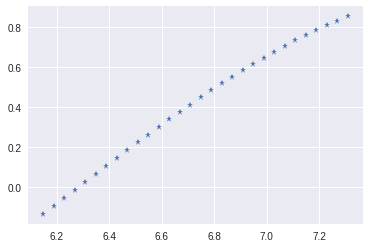

In [12]:
# To plt it you have to flatten it
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

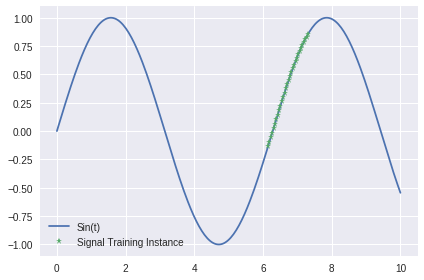

In [13]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Signal Training Instance')
plt.tight_layout()
plt.legend()

# TRAINING DATA

In [0]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

In [15]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

In [16]:
train_inst.shape

(31,)

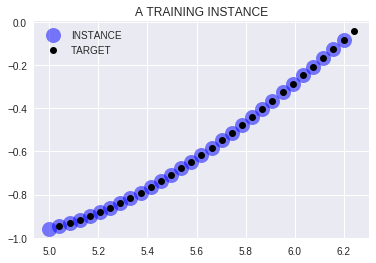

In [17]:
plt.title('A TRAINING INSTANCE')

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='INSTANCE')

plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='TARGET')

plt.legend()

# CREATING THE MODEL

In [0]:
tf.reset_default_graph()

In [0]:
num_inputs = 1



In [0]:
num_neurons = 100

In [0]:
num_outputs = 1

In [0]:
learning_rate = 0.0001

In [0]:
num_train_iterations = 2000

In [0]:
batch_size = 1

#PLACEHOLDER


In [0]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [0]:
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

## RNN CELL LAYER

In [0]:

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell, X,dtype=tf.float32)

In [0]:
# MEAN SQUARED ERROR

loss = tf.reduce_mean(tf.square(outputs-y))


In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [0]:
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [0]:
saver = tf.train.Saver()
  

In [35]:
with tf.Session() as sess:
  
  sess.run(init)
  
  for iteration in range(num_train_iterations):
    
    
    X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
    
    sess.run(train, feed_dict={X: X_batch, y:y_batch})
    
    if iteration % 100 == 0:
      
      
      mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
      
      print(iteration, "\t MSE: ", mse)
  
  saver.save(sess, "./rnn_time_series_model_codealong")
  

0 	 MSE:  0.13654783
100 	 MSE:  0.059156716
200 	 MSE:  0.013028442
300 	 MSE:  0.018538913
400 	 MSE:  0.0070457147
500 	 MSE:  0.024459183
600 	 MSE:  0.0031943473
700 	 MSE:  0.024094108
800 	 MSE:  0.039293896
900 	 MSE:  0.0063056545
1000 	 MSE:  0.01675303
1100 	 MSE:  0.0043518227
1200 	 MSE:  0.00039381732
1300 	 MSE:  0.006222415
1400 	 MSE:  0.0046364088
1500 	 MSE:  0.0008778364
1600 	 MSE:  0.01846873
1700 	 MSE:  0.010317477
1800 	 MSE:  0.019600563
1900 	 MSE:  0.015975894


In [36]:
with tf.Session() as sess:
  
  
  saver.restore(sess, "./rnn_time_series_model_codealong")
  
  
  X_new = np.sin(np.array(train_inst[1:].reshape(-1, num_time_steps, num_inputs)))
  
  y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


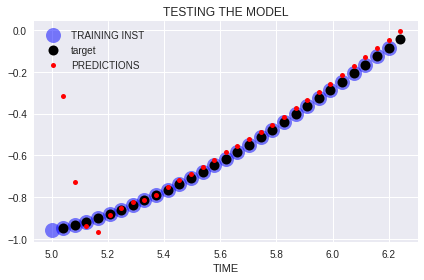

In [37]:
plt.title("TESTING THE MODEL")

# TRAINING INSTANCE
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="TRAINING INST")


# TARGET TO  PREDICT (CORRECT TEST VALUES NPSIN(TRAIN))
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# MODELS PREDICTION

plt.plot(train_inst[1:], y_pred[0, :,0], 'r.', markersize=10, label="PREDICTIONS")

plt.xlabel('TIME')
plt.legend()
plt.tight_layout()

##Generating new sequences

In [41]:
with tf.Session() as sess:
  
  saver.restore(sess, "./rnn_time_series_model_codealong")
  
  #SEED ZEROS
  zero_seq_seed = [0.0 for i in range(num_time_steps)]
  
  for iteration in range(len(ts_data.x_data) - num_time_steps):
    
    X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
    
    y_pred = sess.run(outputs, feed_dict={X: X_batch})
    
    zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0,0.5,'Y')

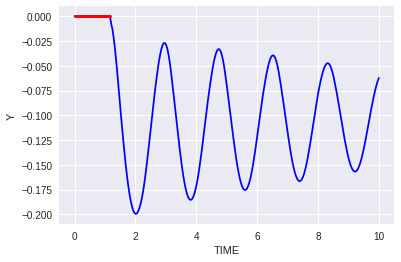

In [45]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps],'r', linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')

In [46]:
with tf.Session() as sess:
  
  saver.restore(sess, "./rnn_time_series_model_codealong")
  
  #SEED ZEROS
  training_instance = list(ts_data.y_true[:30])
  
  for iteration in range(len(training_instance) - num_time_steps):
    
    X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
    
    y_pred = sess.run(outputs, feed_dict={X: X_batch})
    
    training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0,0.5,'Y')

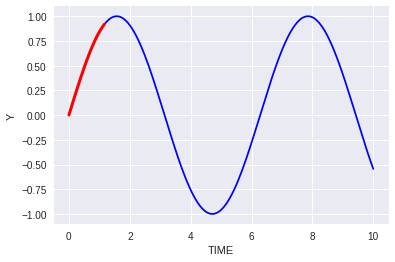

In [48]:
plt.plot(ts_data.x_data,ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps],'r', linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')